# **STEP 1: PROBLEM DESCRIPTION AND DATASET**

This mini-project focuses on the Histopathologic Cancer Detection challenge provided on Kaggle (https://www.kaggle.com/competitions/histopathologic-cancer-detection). The goal of this challenge is to build a binary classification model capable of identifying the presence or absence of metastatic cancer in small image patches of human tissue. Each image is a 96 x 96-pixel RGB patch, extracted from larger histopathology scans, with regions of interest that may contain cancerous cells.

The dataset consists of over 220,000 labeled training images along with a .csv file that provides the labels for each image. Each patch is classified as either cancerous (label 1) or non-cancerous (label 0). Additionally, there is an unlabeled test set of images. The effectiveness of our model will be evaluated by submitting predicted labels for these test images to the Kaggle platform, where the model’s accuracy will be scored.

To tackle this problem, we will employ a Convolutional Neural Network (CNN). CNNs are particularly effective for tasks like this, where subtle visual patterns within the image data are key to accurate classification. Through convolutional and pooling layers, CNNs detect features such as edges, shapes, textures, and more complex patterns that signify cancerous tissue. These layers progressively simplify the image while preserving essential characteristics, allowing the network to identify small differences between healthy and cancerous cells. The final layers produce binary predictions based on the refined features, making CNNs well-suited for this classification task.


In [1]:
# Import necessary libraries
import gdown
import os
import zipfile
import numpy as np
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **STEP 2: EXPLORATORY DATA ANALYSIS (EDA)**

The train and test files are stored on Google Drive in separate zipped folders. We begin by importing the files and unzipping them for analysis. Our EDA will take the following steps:
<br><br>
1. **Basic Data Structure and Summary:** We will check for missing labels in the training set file, as well as whether any duplicate entries exist. Since the data shows no missing or duplicate values, we will proceed to examine the balance between the two classes of labels. There appears to be a close to 60/40 split between the labels, indicating that there is no significant imbalance.

2. **Class Distribution Visualization:** Next, we will create a bar chart to display the total counts for each label in the training dataset. With more than 220,000 total labels, the output of this visualization reinforces our earlier observation of the 60/40 split between the labels.

3. **Inspect Training Labels:** By inspecting the first few training labels, we note that there are no suffixes on the ID column values. Since the images are in .tif format, we will need to append these suffixes to ensure correct matching.

4. **Create a Validation Set:** Using the training images, we will divide the dataset into an 80/20 split for training and validation. This division will allow us to validate our model on a portion of the data that has not been used for training.

5. **Display Sample Images:** To gain a visual understanding of the dataset, we will display some sample images. It’s clear that differentiating between class labels may be challenging without domain expertise, highlighting the importance of model training in accurately classifying these images.

In [2]:
# Set the URLs for Google Drive files
train_zip_url = 'https://drive.google.com/uc?id=1Ggk1lwpyeWQb132lxj2aCHDYWCnAqlDB'
test_zip_url = 'https://drive.google.com/uc?id=1SprGtbkzSQYg0NvivvXRR8y9-pcEL2Dz'
train_labels_url = 'https://drive.google.com/uc?id=18PlnWCecRnT9YeN0k9jbAQfeN7P1fNUY'

# Download the files
gdown.download(train_zip_url, 'train.zip', quiet=False)
gdown.download(test_zip_url, 'test.zip', quiet=False)
gdown.download(train_labels_url, 'train_labels.csv', quiet=False)

# Create directories for extracted files
os.makedirs('train', exist_ok=True)
os.makedirs('test', exist_ok=True)

# Unzip the training and test data
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')

# Load the train labels
train_labels = pd.read_csv('train_labels.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1Ggk1lwpyeWQb132lxj2aCHDYWCnAqlDB
From (redirected): https://drive.google.com/uc?id=1Ggk1lwpyeWQb132lxj2aCHDYWCnAqlDB&confirm=t&uuid=455540e7-be67-4e61-a2ea-537384b72304
To: /content/train.zip
100%|██████████| 5.46G/5.46G [00:36<00:00, 148MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1SprGtbkzSQYg0NvivvXRR8y9-pcEL2Dz
From (redirected): https://drive.google.com/uc?id=1SprGtbkzSQYg0NvivvXRR8y9-pcEL2Dz&confirm=t&uuid=19199d0f-e3fe-4c9c-b84d-2015390abf27
To: /content/test.zip
100%|██████████| 1.43G/1.43G [00:16<00:00, 86.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=18PlnWCecRnT9YeN0k9jbAQfeN7P1fNUY
To: /content/train_labels.csv
100%|██████████| 9.46M/9.46M [00:00<00:00, 51.7MB/s]


In [3]:
# Inspect the training labels
print("Missing values in train_labels:\n", train_labels.isnull().sum())
print("\nNumber of duplicate entries in train_labels:", train_labels.duplicated().sum())
print("\nClass distribution:\n", train_labels['label'].value_counts(normalize=True))

Missing values in train_labels:
 id       0
label    0
dtype: int64

Number of duplicate entries in train_labels: 0

Class distribution:
 label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


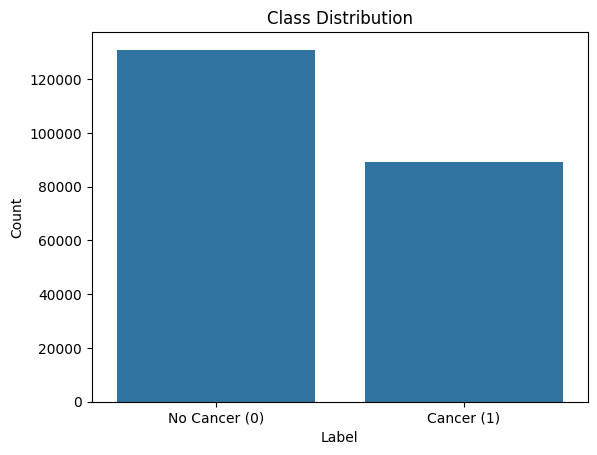

In [4]:
# Visualize the class distribution
sns.countplot(x='label', data=train_labels)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Cancer (0)', 'Cancer (1)'])
plt.show()

In [5]:
# Inspect the first training labels
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


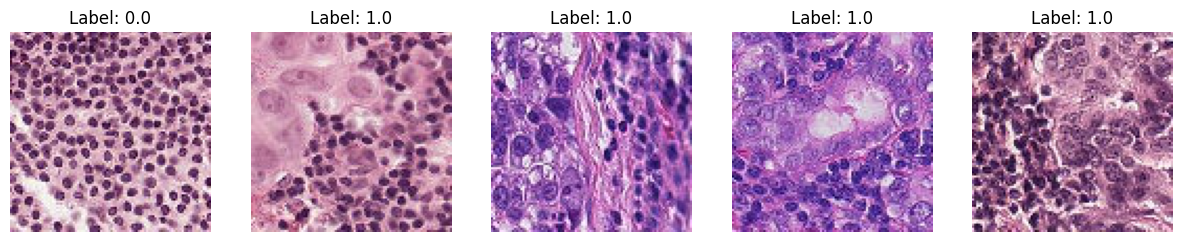

In [6]:
# Data generator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

# Convert the 'label' column to strings
train_labels['label'] = train_labels['label'].astype(str)

# Add the suffix .tif to the id strings
train_labels['id'] = train_labels['id'].apply(lambda x: f"{x}.tif")

# Create training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='train/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Create validation data generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='train/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Display sample images
def display_sample_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

    plt.show()

display_sample_images(train_generator, num_images=5)

# **STEP 3: MODEL ARCHITECTURE**

Our initial model is a straightforward Convolutional Neural Network (CNN) with three convolutional layers, each followed by a max-pooling layer. Here’s an overview of each layer type and why it’s included:
<br><br>
**Convolutional Layers:** Using 3x3 filters, we increase the number of filters across layers (32, 64, and 128) to capture both fine-grained details in the early layers and higher-level patterns in the deeper layers. This progression allows the model to detect subtle differences between healthy and cancerous cells. The ReLU activation function is applied to introduce non-linearity, enabling the network to capture complex patterns in the data.

**Max-Pooling Layers:** Following each convolutional layer, max-pooling layers reduce the dimensionality by a factor of 2. This down-sampling helps control model complexity by reducing parameters and focuses on the most prominent features, making the network more efficient and less prone to overfitting.
Flatten Layer: This layer converts the 3D output from the final convolutional layer into a 1D array, preparing the data for the dense layers by making the features compatible with the fully connected structure.

**Fully Connected (Dense) Layer:** After flattening, the first dense layer learns relationships between the features extracted by the convolutional layers. With 128 neurons and ReLU activation, this layer can recognize complex patterns, which are essential for accurate classification. The final dense layer has a single neuron with a sigmoid activation function, which outputs a probability score between 0 and 1, indicating the likelihood of cancerous cells being present. This setup is ideal for binary classification tasks.
<br><br>
To enhance the model’s robustness and reduce overfitting, we include the following:
<br><br>
**Dropout Layer:** A dropout layer between the fully connected layers randomly disables neurons during training, which helps prevent over-reliance on specific neurons and encourages the network to learn more generalized features.
<br><br>
After training of this architecture, we will evaluate its performance on the validation set, focusing on metrics such as accuracy and loss.


In [7]:
# Build CNN model
def create_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(96, 96, 3)))  # Input layer

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the model
model = create_model()

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 161s 29ms/step - accuracy: 0.7791 - loss: 0.4752 - val_accuracy: 0.8611 - val_loss: 0.3260
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 155s 28ms/step - accuracy: 0.8670 - loss: 0.3195 - val_accuracy: 0.8936 - val_loss: 0.2664
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - accuracy: 0.8874 - loss: 0.2777 - val_accuracy: 0.8965 - val_loss: 0.2685
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - accuracy: 0.9018 - loss: 0.2449 - val_accuracy: 0.9012 - val_loss: 0.2488
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - accuracy: 0.9124 - loss: 0.2208 - val_accuracy: 0.9090 - val_loss: 0.2285
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 155s 28ms/step - accuracy: 0.9209 - loss: 0.2041 - val_accuracy: 0.9078 - val_loss: 0.2413
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - accuracy: 0.9253 - loss: 0.1896 - val_accuracy: 0.9050 - val_loss: 0.2483
Epoch 8/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 155s 28ms/step - accuracy: 

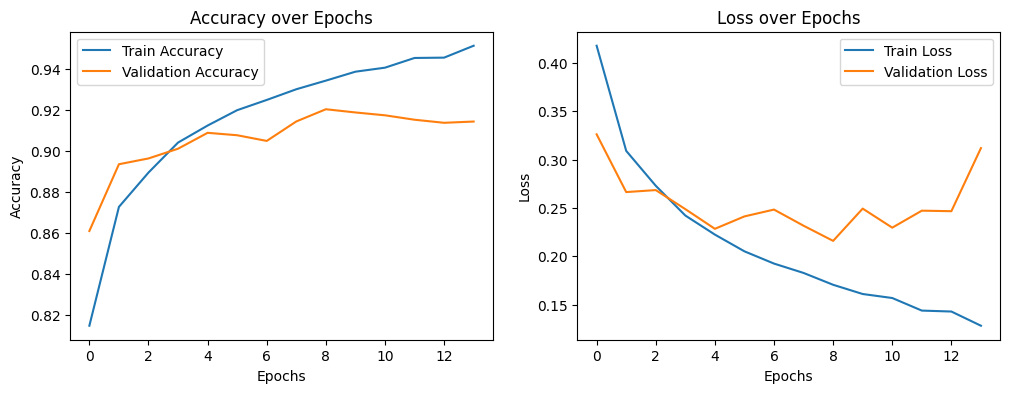

In [12]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_history(history)

In [13]:
test_dir = 'test/test'
test_files = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]
test_df = pd.DataFrame({'filename': test_files})

# Test generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Make predictions on dataset
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

# Prepare submission dataframe
submission_df = pd.DataFrame({
    'id': [os.path.splitext(os.path.basename(fname))[0] for fname in test_files],
    'label': predicted_classes.flatten()  # Flatten to 1D
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step
Submission file created: submission.csv


In [14]:
# Download submission file
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

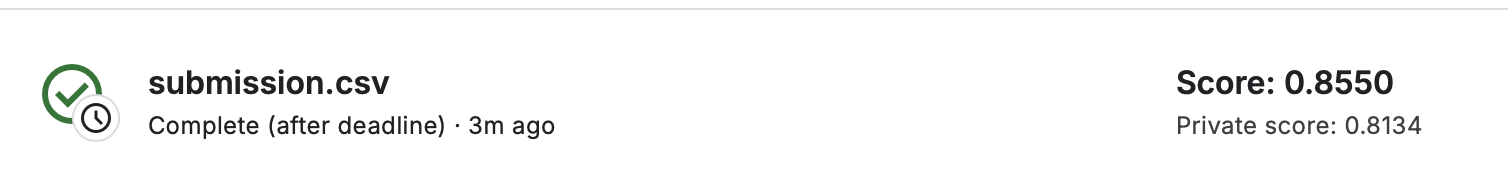

# **STEP 4: RESULTS AND ANALYSIS**

The initial model performed well, achieving a validation accuracy of 92.0% and a Kaggle public leaderboard score of 85.5%. However, the private score was slightly lower at 81.3%, suggesting potential overfitting to the validation data. Additionally, we observed that the model’s performance plateaued around 10 epochs. Despite setting the model to train for 20 epochs, the EarlyStopping callback intervened when no further improvement in validation loss was detected, confirming that additional training was unlikely to enhance performance.
<br><br>
To further optimize the model and improve generalization for Kaggle’s private test set, we propose the following strategies:
<br><br>
**Data Augmentation:** By applying more robust data augmentation through the ImageDataGenerator, we can introduce more variations in the training data, potentially enhancing the model’s ability to generalize to new, unseen data.
<br><br>
**Learning Rate Tuning:** Adjusting the learning rate to a slightly lower value could strike a better balance between training speed and accuracy, reducing the risk of overfitting while potentially improving generalization.

In [8]:
# Data Augmentation
augmented_train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Keep the validation split
)

# Augmented training generator
augmented_train_generator = augmented_train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='train/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation generator (unchanged)
augmented_val_generator = augmented_train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='train/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define and compile a new model with a reduced learning rate
optimized_model = create_model()  # Reuse the function for consistency
optimized_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Train the optimized model with augmented data
history_optimized = optimized_model.fit(
    augmented_train_generator,
    epochs=20,
    validation_data=augmented_val_generator,
    callbacks=[early_stopping]
)

# Evaluate the optimized model on validation data
val_loss_opt, val_accuracy_opt = optimized_model.evaluate(augmented_val_generator)
print(f'Optimized Validation Loss: {val_loss_opt}, Optimized Validation Accuracy: {val_accuracy_opt}')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 637s 115ms/step - accuracy: 0.7668 - loss: 0.4945 - val_accuracy: 0.8263 - val_loss: 0.3937
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 626s 114ms/step - accuracy: 0.8220 - loss: 0.4057 - val_accuracy: 0.8428 - val_loss: 0.3647
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 624s 113ms/step - accuracy: 0.8454 - loss: 0.3601 - val_accuracy: 0.8645 - val_loss: 0.3198
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 624s 113ms/step - accuracy: 0.8581 - loss: 0.3354 - val_accuracy: 0.8735 - val_loss: 0.3035
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 624s 113ms/step - accuracy: 0.8686 - loss: 0.3138 - val_accuracy: 0.8697 - val_loss: 0.3043
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 624s 113ms/step - accuracy: 0.8770 - loss: 0.2973 - val_accuracy: 0.8868 - val_loss: 0.2737
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 626s 114ms/step - accuracy: 0.8845 - loss: 0.2809 - val_accuracy: 0.8851 - val_loss: 0.2823
Epoch 8/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 625s 114ms/step - accuracy: 0.8

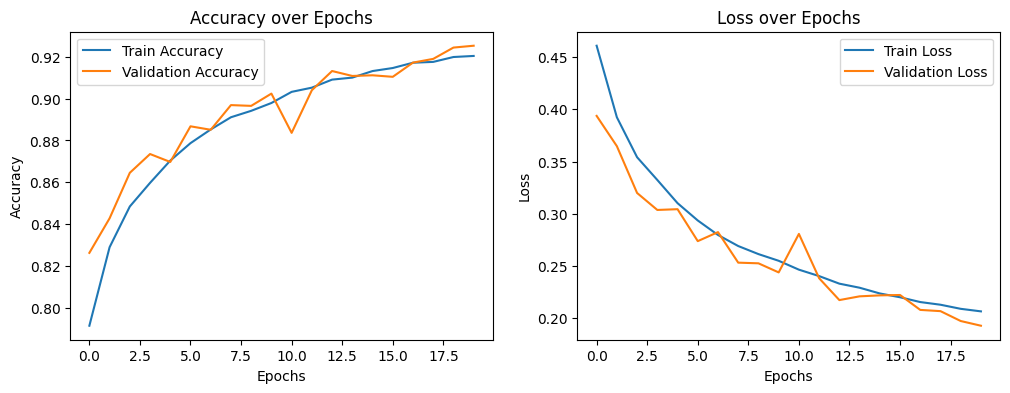

In [15]:
# Plot the training history for the optimized model
plot_history(history_optimized)

In [16]:
# Predictions on testing set using opitmized model
predictions_opt = optimized_model.predict(test_generator)
predicted_classes_opt = (predictions_opt > 0.5).astype(int)
submission_df_opt = pd.DataFrame({
    'id': [os.path.splitext(os.path.basename(fname))[0] for fname in test_files],
    'label': predicted_classes_opt.flatten()
})

# Create optimized_submission file
submission_df_opt.to_csv('optimized_submission.csv', index=False)
print("Optimized submission file created: optimized_submission.csv")

# Download optimized_submission file
files.download('optimized_submission.csv')

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step
Optimized submission file created: optimized_submission.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

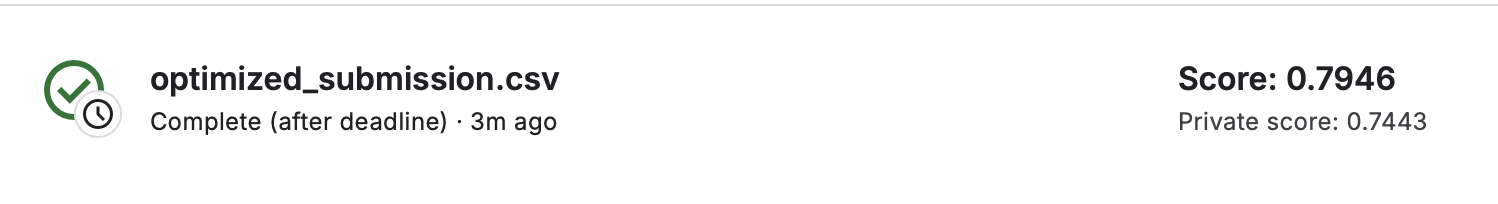

# **STEP 5: CONCLUSION**

In this project, we focused on detecting metastatic cancer in histopathologic sample images using a convolutional neural network (CNN). Our initial model achieved respectable validation accuracy but showed signs of overfitting, as reflected by a disparity between the public and private leaderboard scores on Kaggle. This issue was also evident in the divergence of training and validation accuracy and loss curves as the number of epochs increased.

By incorporating data augmentation and tuning the learning rate, we improved the model’s generalization, with the optimized model reaching a validation accuracy of 92.79%. Aggressive data augmentation made the model more robust to variations in the training images, and a tuned learning rate allowed for more effective convergence. However, these adjustments may have introduced additional overfitting, as suggested by the Kaggle leaderboard scores (private score of 0.7443 and public score of 0.7946), which indicate that the model’s performance on unseen data remains below expectations. This could suggest that we added complexity without significantly enhancing feature extraction.

Looking ahead, we could explore additional regularization techniques, such as batch normalization, to stabilize training and improve generalization. Testing alternative architectures, like deeper CNNs or pretrained models, may also help capture more intricate patterns in the data. Additionally, techniques such as stochastic weight averaging (SWA) or model ensembling could further improve model stability and accuracy, particularly on challenging test sets. Overall, this project highlighted the strengths of CNNs for image classification and underscored the importance of careful tuning to achieve optimal performance on complex, real-world data.